# Prerequsites

In [1]:
# log the time of the experiment
from datetime import datetime
import time

exp_time = datetime.now()
exp_time_str = exp_time.strftime("_%H_%M_%S")
date_str = exp_time.strftime("%m_%d_%y")

In [2]:
# Path management for MacOS and Windows
from pathlib import Path
import os, sys

scriptPath = Path(sys.path[0])
parentPath = Path(sys.path[0]).parent

libPath = parentPath
sys.path.append(libPath.as_posix())

# Set the working directory (to save the files)
resultPath = scriptPath

slmWeightPath = resultPath / "slm_weights"
if not os.path.exists(slmWeightPath.as_posix()):
    os.makedirs(slmWeightPath.as_posix())
    
phoneImagePath = resultPath / "phone_images"
if not os.path.exists(phoneImagePath.as_posix()):
    os.makedirs(phoneImagePath.as_posix())
    
saveDataPath = resultPath / "saved_data"
if not os.path.exists(saveDataPath.as_posix()):
    os.makedirs(saveDataPath.as_posix())
    
print(resultPath)

D:\McMahon lab Dropbox\peter mcmahon\tw329\Experiments\11_26_20_MPPC_STL10_More_RandDotProd


In [3]:
# Load some libraries
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import numpy as np
import pandas
from PIL import Image

In [4]:
%matplotlib notebook

# Instrument Controls

In [5]:
# Configure the SLM
from SLM.slmpy import SLMdisplay   # Popoff's simple package for controlling SLM

slm = SLMdisplay(isImageLock = True)

LUT_used="AmpLUT_basedon_100120slmbackcali_140509_start5.lut"

slmParamFile = resultPath / ''.join(["slm_info", exp_time_str, ".txt"])
with open(slmParamFile,'w') as slmparams:
    slmparams.write('LUT\t\t\t{}\n'.format(LUT_used))
slmparams.close()


C:/Users/Logan/Documents/GitHub/ONN_MNIST\src\slmpy.py:39: wxPyDeprecationWarning: Call to deprecated item EmptyImage. Use :class:`Image` instead.
  self.img = wx.EmptyImage(2,2)


In [6]:
import pyvisa
from Oscilloscope import Agilent54845A as AgilentOscope

rm = pyvisa.ResourceManager("C:\\WINDOWS\\System32\\visa64.dll")
gpib_id = rm.list_resources()[-1]
oscope = AgilentOscope(rm.open_resource(gpib_id))
oscope.set_waveform_source(1)

def oscope_info(oscope):
    measure_state = {}
    measure_state["ID"] = oscope.id()
    measure_state["x_range"] = oscope.get_xrange()
    measure_state["x_unit"] = oscope.get_xunits()
    measure_state["y_range"] = oscope.get_yrange()
    measure_state["y_unit"] = oscope.get_yunits()
    measure_state["y_offset"] = oscope.get_offset()
    measure_state["y_bounds"] = [oscope.get_bottom_bound(), oscope.get_top_bound()]
    return measure_state

In [7]:
# Configure the phone

from Android_Display_Control.Remote_Display.image_stream import AndroidOpenAccessoryBridge as AOAB

PIXEL_VENDOR_ID = 0x18d1
PIXEL_UNCONFIG_ID =  0x4ee7
PIXEL_CONFIG_ID = 0x2d01

# Create an AOAB object for managing data send/receive via USB
aoab = AOAB(PIXEL_VENDOR_ID, PIXEL_UNCONFIG_ID, 
  PIXEL_CONFIG_ID,
  manufacturer='ImageStreamManufacturer',
  model='ImageStream1',
  description='Stream Images to Android',
  version=1,
  uri=('https://github.com/chris-blay/android-open-accessory-bridge'),
  serial='AoabSerial')

Exception ignored in: <function _AutoFinalizedObjectBase.__del__ at 0x000001754E6F6BF8>
Traceback (most recent call last):
  File "C:\Users\Logan\Anaconda3\lib\site-packages\usb\_objfinalizer.py", line 84, in __del__
    self.finalize()
  File "C:\Users\Logan\Anaconda3\lib\site-packages\usb\_objfinalizer.py", line 144, in finalize
    self._finalizer()
  File "C:\Users\Logan\Anaconda3\lib\weakref.py", line 552, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
  File "C:\Users\Logan\Anaconda3\lib\site-packages\usb\_objfinalizer.py", line 104, in _do_finalize_object_ref
    obj._do_finalize_object()
  File "C:\Users\Logan\Anaconda3\lib\site-packages\usb\_objfinalizer.py", line 71, in _do_finalize_object
    self._finalize_object()
  File "C:\Users\Logan\Anaconda3\lib\site-packages\usb\backend\libusb1.py", line 604, in _finalize_object
    _lib.libusb_unref_device(self.devid)
OSError: exception: access violation writing 0x0000000000000024


In [8]:
def PIL_to_bytestream(img_px):
    array_px = np.array(img_px)
    byte_array_px = bytearray()

    for i in range(array_px.shape[0]):
        for j in range(array_px.shape[1]):
            byte_array_px.append(array_px[i, j, 0])
            byte_array_px.append(array_px[i, j, 1])
            byte_array_px.append(array_px[i, j, 2])

    assert(len(byte_array_px) == 1920*1080*3)
    return byte_array_px

In [9]:
# Load the phone pixel LUT
lut_p = torch.zeros(1000, dtype=torch.uint8) 
with open((resultPath/'PhoneLUT_100120_161444c30et20ms_1000.lut').as_posix(),'r') as lutfile:
        for i in range(len(lut_p)):
            aline = lutfile.readline().split()
            lut_p[i] = int(aline[1])
lutfile.close()

# Other Utility Functions

In [10]:
# Define utility functions for generating block patterns on both phone and SLM

from math import sqrt
from PIL import Image
import imageio


def save_image_stack(fName, path, imglist):
    imgPath = path / fName
    imageio.mimwrite(imgPath, np.asarray(imglist))
    return imgPath

def Wrap_vec_to_square (idx_vec, null_element=torch.tensor([-1])):
    
    if isinstance(null_element, int):
        null_element = torch.tensor([null_element])
        
    a = int(sqrt(len(idx_vec)))
    if len(idx_vec) < a*(a+1):
        px_col_counts = a
        last_row_supplements = a - 1 - (idx_vec.numel()-1)%a 
    if len(idx_vec) >= a*(a+1):
        px_col_counts = a+1
        last_row_supplements = a - (idx_vec.numel()-1)%(a+1)
    
    idx_vec = torch.cat((idx_vec, torch.repeat_interleave(null_element, last_row_supplements)))
    idx_vec = idx_vec.view(-1, px_col_counts)
    
    return idx_vec

from matplotlib import colors

def read_image_stack(fName, path):
    imgPath = path / fName
    return np.array(imageio.volread(imgPath))

def compare_plot(img1,img2,title1="img1",title2="img2",suptitle=None):
    fig, axs = plt.subplots(1,2,constrained_layout=True)
    if suptitle is not None:
        fig.suptitle(suptitle)
    ax1 = axs[0].imshow(img1)
    ax2 = axs[1].imshow(img2)
    axs[0].set_title(title1)
    axs[1].set_title(title2)
    axs[0].set_xlabel(f"std/mean = {img1.std():.4g}/{img1.mean():.4g} = {100.*img1.std()/img1.mean():.3g}%")
    axs[1].set_xlabel(f"std/mean = {img2.std():.4g}/{img2.mean():.4g} = {100.*img2.std()/img2.mean():.3g}%")
    # Find the min and max of all colors for use in setting the color scale.
    vmin = min(image.get_array().min() for image in [ax1,ax2])
    vmax = max(image.get_array().max() for image in [ax1,ax2])
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    for im in [ax1,ax2]:
        im.set_norm(norm)
        
    fig.colorbar(ax2, ax=axs, orientation='horizontal', fraction=.04)
    plt.show()
    
def plot_maxmin(img):
    plt.figure()
    plt.contourf(img)
    plt.colorbar()
    plt.title(f"max/min = {img.max():.1f}/{img.min():.1f} = {img.max()/img.min():.2f}")
    plt.xlabel(f"std/mean = {img.std():g}/{img.mean():g} = {img.std()/img.mean():g}")
    plt.show()
def im_maxmin(img):
    plt.figure()
    plt.imshow(img)
    plt.colorbar()
    plt.title(f"max/min = {img.max():.1f}/{img.min():.1f} = {img.max()/img.min():.2f}")
    plt.xlabel(f"std/mean = {img.std():g}/{img.mean():g} = {img.std()/img.mean():g}")
    plt.show()

# Correction Mask

In [11]:
f_list = []
for f in os.listdir(saveDataPath):
    if f.endswith('.pkl'):
        f_list.append(f)
f_list

['phonemask_blk600x600_antiatt_phone_mask_onsite_lb640_1_1012_092948.bmp.pkl',
 'phonemask_blk600x600_antiatt_phone_mask_raw_1012_092948.pkl',
 'phonemask_blk720x720_antiatt_phone_mask_onsite_lb450_1_1015_233224.bmp.pkl',
 'phonemask_blk720x720_antiatt_phone_mask_raw_1015_233224.pkl']

<IPython.core.display.Javascript object>


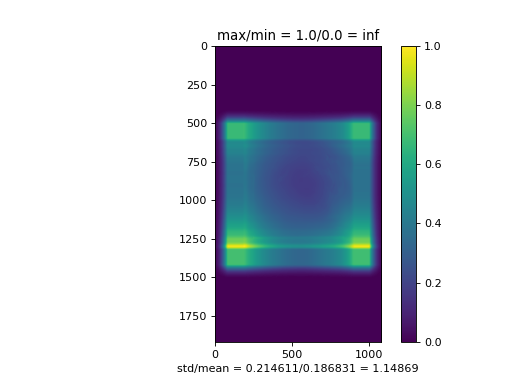

C:\Users\Logan\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in double_scalars


In [12]:
import joblib
maskPath = saveDataPath
maskName = "phonemask_blk720x720_antiatt_phone_mask_onsite_lb450_1_1015_233224.bmp.pkl"
mask_str = "onsite"
# maskName = "blk600x600_antiatt_phone_mask_raw_0911_142600.bmp"
# mask_str = "rawmask"
phone_mask = joblib.load(saveDataPath / maskName)
# if len(mask.shape)==3:
#     mask = mask[:,:,1]
phone_mask
im_maxmin(phone_mask)

# Generate Random Binary Vectors from STL10 Dataset

In [13]:
# Image binarize functions
def binarize_img_by_percentile(img, rate):
    img_b = (img<=np.percentile(img.numpy(), rate))
    res_ones = int(img_b.sum() - rate/100.0 * img_b.numel())
    vec_b = img_b.flatten()
    vec_b[vec_b.nonzero()[:res_ones]] = 0
    return vec_b.view(img_b.shape)

def add_surr(img,expan_r):
    img_shape = np.array(img.shape)
    expan_img = np.zeros(img_shape*expan_r)
    expan_img[expan_r//2::expan_r,expan_r//2::expan_r] = img
    return expan_img

def expand_pixels(img, expan_r):
    img_temp = torch.repeat_interleave(img, expan_r, dim=0)
    return torch.repeat_interleave(img_temp, expan_r, dim=1)

def Add_frame(pic, frame_px_value):
    
    frame = torch.zeros(pic.shape[0]+40, pic.shape[1]+40, dtype=pic.dtype)
    frame[[0,-1],:] = frame_px_value
    frame[:,[0,-1]] = frame_px_value
    frame[20:-20, 20:-20] = pic
    
    return frame

In [14]:
""" Load STL10 dataset to generate random binary vectors 
STL10 is composed of RGB images of size 96x96 belonging to 10 classes.""" 

transform = transforms.Compose(
    [transforms.Resize(100),
     transforms.ToTensor()])

trainset = torchvision.datasets.STL10(root='../STL10_Data', split='train',
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=False, num_workers=3)

classes = ("airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck")

Files already downloaded and verified


<IPython.core.display.Javascript object>


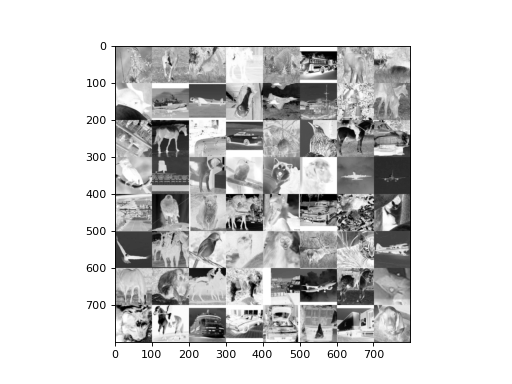

 bird   dog  bird horse   cat truck monkey  deer   dog  ship airplane horse airplane  ship monkey horse  deer horse   car   car  bird  bird horse   car  bird  ship   dog  bird   dog   dog airplane airplane airplane  bird   cat horse monkey   car  bird   cat  bird horse  bird   cat monkey  deer   cat airplane horse monkey horse   dog  ship airplane horse  bird   cat horse  ship   car   car truck truck   dog


In [15]:
# Test view of the grid of images
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
plt.figure()
plt.imshow(torchvision.utils.make_grid(images, padding=0, nrow=8)[2,:,:], cmap="binary")
plt.show()
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(images.size(0))))

tensor(252761) 252760.5


C:\Users\Logan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  


<IPython.core.display.Javascript object>


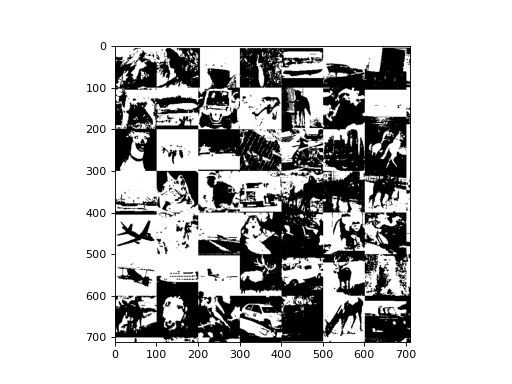

In [16]:
# Test image binarize functions
images, labels = dataiter.next()
x = torchvision.utils.make_grid(images, padding=0, nrow=8)[2,:,:]
rate = 50
xb = binarize_img_by_percentile(x[0:711,0:711], rate)
print(xb.sum(), rate/100.0 * xb.numel() )
plt.figure()
plt.imshow(xb, cmap="binary")
plt.show()

In [17]:
import copy
def quantize_img(norm_img, n_lvl):
    """
    norm_img is expected to have the full pixel range normalized to be 0~1
    """
    if norm_img.max()==0:
        img_q = norm_img*0.
        return img_q
    img_q = (norm_img*(n_lvl-1)).round()/(n_lvl-1)
    return img_q

def shift_quant_img(img, n_lvl, shift):
    img_s = img/img.max() + shift
    img_s[img_s>1] = 1.
    img_s[img_s<0] = 0.
    img_sn = quantize_img(img_s, n_lvl)
    return img_sn

<IPython.core.display.Javascript object>


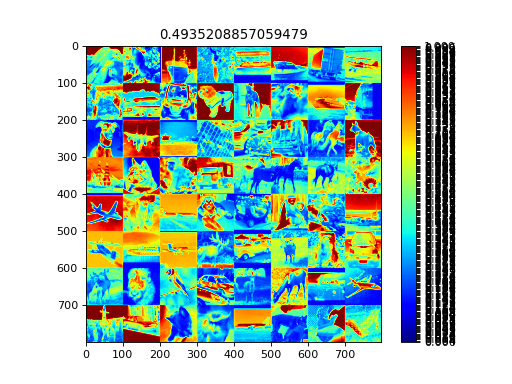

In [18]:
n = 256
sh = 0.1
xn = shift_quant_img(x,n,sh)
plt.figure()
cmap = plt.cm.get_cmap('jet', n)  
plt.imshow(xn, cmap=cmap, vmax=1., vmin=0.)
plt.title(float(xn.mean()))
plt.colorbar(ticks=np.linspace(0,1,n))
plt.show()

<IPython.core.display.Javascript object>


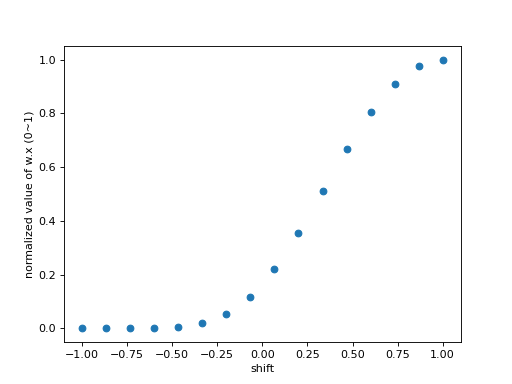

Text(0, 0.5, 'normalized value of w.x (0~1)')

In [19]:
test_sh = np.linspace(-1,1,16)
img = torchvision.utils.make_grid(dataiter.next()[0], padding=0, nrow=8) 
x = img[2] # Take the blue channel of the images
w = img[0]  # Take the red channel of the images
w = torch.flip(w, [0, 1]) 
test_int = []
for shift in test_sh:
    xn = (shift_quant_img(x,16,shift)*255)
    wn = (shift_quant_img(w,16,shift)*255)
    test_int.append(float((wn/255.*xn/255.).sum())/float(xn.size()[0]*xn.size()[1]))
test_int = np.array(test_int)
plt.figure()
plt.scatter(test_sh,test_int)
plt.xlabel('shift')
plt.ylabel('normalized value of w.x (0~1)')

<IPython.core.display.Javascript object>


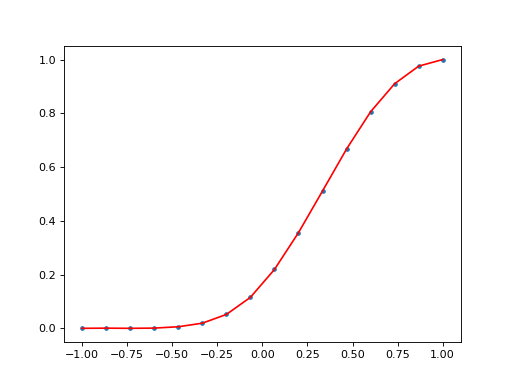

0.0004460220964981288 0.0002500364501633485


In [20]:
from scipy.interpolate import UnivariateSpline
x = test_sh
y = test_int
plt.figure()
plt.scatter(x, y, s=10)

# The parameter is tunable, we want it as small as
# possible to be faithful to the data points
sm_fac = 1e-6

spl1 = UnivariateSpline(x, y)
spl1.set_smoothing_factor(sm_fac)
plt.plot(x, spl1(x), c="red")
print(np.max(spl1(x)-y)/y.max(),np.std(spl1(x)-y)/y.max())

In [21]:
"""
The LUT has 0~n_prec levels (n_prec+1 in total)
that divide 1 into n_prec intervals
"""
n_prec = 1000
shift_lut = np.zeros(n_prec+1,dtype=float)
test_vs = np.linspace(-1,1,n_prec*10)
test_y = spl1(test_vs)
for px in np.arange(n_prec):
    idx = np.argmin((test_y-float(px)/n_prec)**2)
    shift_lut[px] = test_vs[idx]
    print(px,shift_lut[px],'\n')
shift_lut[0] = -1
shift_lut[shift_lut<-1] = -1
shift_lut[n_prec] = 1
shift_lut[shift_lut>1] = 1

0 -0.7765776577657766 

1 -0.5831583158315832 

2 -0.5465546554655465 

3 -0.5191519151915192 

4 -0.4967496749674968 

5 -0.47734773477347736 

6 -0.4601460146014601 

7 -0.44494449444944495 

8 -0.43114311431143115 

9 -0.41854185418541856 

10 -0.4071407140714072 

11 -0.3965396539653965 

12 -0.3867386738673867 

13 -0.3777377737773777 

14 -0.36913691369136914 

15 -0.3611361136113611 

16 -0.3535353535353535 

17 -0.34633463346334636 

18 -0.33953395339533954 

19 -0.33293329332933286 

20 -0.3267326732673267 

21 -0.32073207320732067 

22 -0.3149314931493149 

23 -0.3093309330933093 

24 -0.30413041304130406 

25 -0.29892989298929895 

26 -0.2939293929392939 

27 -0.2889288928892889 

28 -0.28432843284328435 

29 -0.2797279727972797 

30 -0.2751275127512751 

31 -0.27092709270927096 

32 -0.2667266726672667 

33 -0.2625262526252625 

34 -0.2585258525852585 

35 -0.2545254525452545 

36 -0.25072507250725073 

37 -0.24692469246924686 

38 -0.2431243124312431 

39 -0.23952395239523

573 0.38573857385738575 

574 0.38653865386538655 

575 0.38733873387338735 

576 0.38813881388138816 

577 0.38893889388938896 

578 0.38993899389939 

579 0.3907390739073908 

580 0.3915391539153916 

581 0.3923392339233924 

582 0.3933393339333935 

583 0.3941394139413943 

584 0.3949394939493951 

585 0.3957395739573959 

586 0.39673967396739673 

587 0.39753975397539754 

588 0.39833983398339834 

589 0.39913991399139914 

590 0.39993999399939995 

591 0.400940094009401 

592 0.4017401740174018 

593 0.4025402540254026 

594 0.4033403340334034 

595 0.4043404340434045 

596 0.4051405140514053 

597 0.4059405940594061 

598 0.4067406740674069 

599 0.4077407740774077 

600 0.4085408540854085 

601 0.4093409340934093 

602 0.41014101410141013 

603 0.4111411141114112 

604 0.411941194119412 

605 0.4127412741274128 

606 0.41374137413741385 

607 0.41454145414541466 

608 0.41534153415341546 

609 0.41614161416141626 

610 0.4171417141714171 

611 0.4179417941794179 

612 0.41874187

967 0.8435843584358436 

968 0.8461846184618462 

969 0.8487848784878489 

970 0.8513851385138513 

971 0.8541854185418543 

972 0.856985698569857 

973 0.8595859585958596 

974 0.8625862586258626 

975 0.8653865386538655 

976 0.8683868386838685 

977 0.8713871387138714 

978 0.8743874387438744 

979 0.8775877587758776 

980 0.8807880788078808 

981 0.8841884188418843 

982 0.8875887588758877 

983 0.890989098909891 

984 0.8945894589458947 

985 0.8981898189818982 

986 0.901990199019902 

987 0.905990599059906 

988 0.9101910191019102 

989 0.9143914391439145 

990 0.9187918791879188 

991 0.9235923592359236 

992 0.9285928592859287 

993 0.9337933793379338 

994 0.9393939393939394 

995 0.9455945594559456 

996 0.9523952395239526 

997 0.9599959995999601 

998 0.9691969196919692 

999 0.980798079807981 



<IPython.core.display.Javascript object>


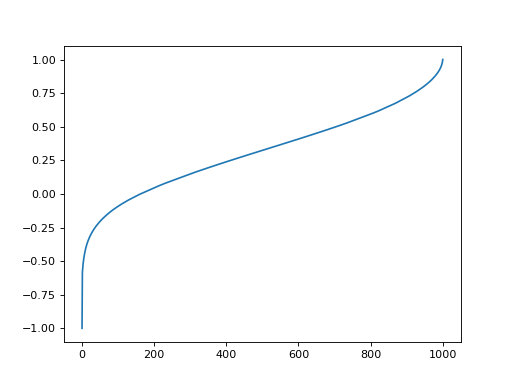

In [22]:
plt.figure()
plt.plot(shift_lut)

In [23]:
""" Drawing random binary vectors and weights from the images """

import numpy as np
import pandas
# from src.kaleidoscope import Kaleidoscope
from utils.helper_functions import ConvertPhoneImageToSLMImage, NormalizeWeights, CenterEmbedding

full_roi_size = 711
expan_r = 1 
side_len = int(full_roi_size//expan_r)

batch_size = 10 # Number of images
shift_size = 16 # Number of shifts for an image
batch_size_total = shift_size*batch_size

n_lvl = 256 # Number of levels in the images
isRand = False
method_str_map = {True: 'randomrates', False: 'fixedrates'}

dataiter = iter(trainloader)

shift_method_str = method_str_map[isRand]
data_name = f"Rand{n_lvl}lvl_{side_len}x{side_len}_STL10_{shift_method_str}_{batch_size}x{shift_size}"
gen_img_name = f"{mask_str}_spar{expan_r}"

phoneSavePath = phoneImagePath / f"{data_name}_{gen_img_name}"
if not os.path.exists(phoneSavePath.as_posix()):
    os.makedirs(phoneSavePath.as_posix())
print(phoneSavePath)    

slmSavePath = slmWeightPath / f"{data_name}_{gen_img_name}"
if not os.path.exists(slmSavePath.as_posix()):
    os.makedirs(slmSavePath.as_posix())
print(slmSavePath)

D:\McMahon lab Dropbox\peter mcmahon\tw329\Experiments\11_26_20_MPPC_STL10_More_RandDotProd\phone_images\Rand256lvl_711x711_STL10_fixedrates_10x16_onsite_spar1
D:\McMahon lab Dropbox\peter mcmahon\tw329\Experiments\11_26_20_MPPC_STL10_More_RandDotProd\slm_weights\Rand256lvl_711x711_STL10_fixedrates_10x16_onsite_spar1


In [24]:
blankImage = torch.zeros(3, 1920, 1080, dtype=torch.uint8)
linear_phone_lut = lut_p.unique()

phone_random_binary_raw = {}
phone_random_binary_corr = {}
slm_random_binary_raw = {}
slm_random_binary_corr = {}

rand_xs = {}
rand_ws = {}

np.random.seed(0)

for k, unit_len in enumerate([1,]): 
    rand_xs_per_size = {}
    rand_ws_per_size = {}
    total_macs = side_len**2
            
    for idx in range(batch_size):
        img = torchvision.utils.make_grid(dataiter.next()[0], padding=0, nrow=8) 
        x = img[2, :side_len, :side_len] # Take the blue channel of the images
        img = torchvision.utils.make_grid(dataiter.next()[0], padding=0, nrow=8) 
        w = img[0, :side_len, :side_len]  # Take the red channel of the images
        w = torch.flip(w, [0, 1]) # Flip the image grid to avoid overlapping with x (w,x are derived from the same image grid from different color channel).s
             
        xb_rates = torch.zeros((shift_size,total_macs))
        wb_rates = torch.zeros(xb_rates.shape)
        
        shift_list = []
        for (si, tot_inten) in enumerate(np.linspace(0,1,shift_size)):
            if isRand: 
                if not (tot_inten==0 or tot_inten==1):
                    tot_inten = np.random.rand()
            shift = shift_lut[int(tot_inten*n_prec)]
            shift_list.append(shift)
            
            xb = (shift_quant_img(x,n_lvl,shift)*255).type(torch.uint8)
            vectorBlocks = torch.from_numpy(add_surr(xb, expan_r)).type(torch.uint8)
#             xb = binarize_img_by_percentile(x, rate).type(torch.uint8)*255
            #print(f"fill_frac={xb.sum()}/{xb.numel()}={xb.sum()/255.0/xb.numel()}")
#             vectorBlocks = torch.from_numpy(add_surr(xb, expan_r)).type(torch.uint8)
        
            xb_rates[si,:] = xb.view(-1)
            
            phoneImage = blankImage.clone() # copy the black image as the base canvas
            phoneImage[1, :, :] = CenterEmbedding(Add_frame(vectorBlocks, 0), phoneImage[1,:,:])
            #phone_random_binary_raw[rate, idx] = phoneImage
            
            phoneImage_uncorr = blankImage.clone()
            phoneImage_uncorr[1, :, :] = lut_p[(phoneImage[1, :, :]/255*999).long()]
            phoneImage_PIL = transforms.ToPILImage()(phoneImage_uncorr)
            phoneImage_PIL.save((phoneSavePath / f"phone_random_8bit_{idx}_{si}.png").as_posix())
            """"""
            phoneImage_corr = blankImage.clone()
            phone_corr_numpy = np.array(lut_p[np.array(phoneImage[1, :, :],dtype=float)*phone_mask/255.*999],dtype='uint8')
            phoneImage_corr[1, :, :] = torch.from_numpy(phone_corr_numpy)
            phoneImage_PIL = transforms.ToPILImage()(phoneImage_corr)
            phoneImage_PIL.save((phoneSavePath / f"phone_random_8bit_corr_{idx}_{si}.png").as_posix())
            """"""
            
            wb = (shift_quant_img(w,n_lvl,shift)*255).type(torch.uint8)
            weightBlocks = expand_pixels(wb, expan_r).type(torch.uint8)
            
            wb_rates[si,:] = wb.view(-1)
            
            slmImage = blankImage.clone() # copy the black image as the base canvas
            slmImage[1, :, :] = CenterEmbedding(Add_frame(weightBlocks, 0), slmImage[1,:,:])
            slm_random_binary_raw[idx] = ConvertPhoneImageToSLMImage(slmImage[1, :, :], 1.0)
            slm_random_binary_raw[idx].save((slmSavePath / f"slm_random_8bit_{idx}_{si}.bmp").as_posix(), format = 'bmp')
            
        rand_xs_per_size[idx] = pandas.DataFrame(xb_rates.detach().numpy(),index=np.arange(shift_size))
        rand_ws_per_size[idx] = pandas.DataFrame(wb_rates.detach().numpy(),index=np.arange(shift_size))
    rand_xs[unit_len] = pandas.concat(rand_xs_per_size, axis=0, keys=rand_xs_per_size.keys(), names=["img_group", "shift"])
    rand_ws[unit_len] = pandas.concat(rand_ws_per_size, axis=0, keys=rand_ws_per_size.keys(), names=["img_group", "shift"]) 

df_rand_xs = pandas.concat(rand_xs, axis=0, keys=rand_xs.keys(), names=["block_size", "img_group", "shift"]) 
df_rand_ws = pandas.concat(rand_ws, axis=0, keys=rand_ws.keys(), names=["block_size", "img_group", "shift"]) 

# Generate and save a black image to be displayed on the phone for background and power saving.
blackImage_PIL = transforms.ToPILImage()(blankImage)
blackImage_PIL.save((phoneImagePath / "black.png").as_posix()) 

df_rand_xs.to_hdf((resultPath / f"{data_name}.h5").as_posix(), key="x", mode='w')
df_rand_ws.to_hdf((resultPath / f"{data_name}.h5").as_posix(), key="w", mode='a')

# Scan the phone pixel value and measure the average power

In [25]:
""" Set up MPPC experiment scheme. """
repeats = 100
oscope.set_range(6)
oscope.set_offset(2)
oscope_info(oscope)

{'ID': 'HEWLETT-PACKARD,54845A,US40240103,A.04.50\n',
 'x_range': 0.0001,
 'x_unit': 'SECOND',
 'y_range': 6.0,
 'y_unit': 'VOLT',
 'y_offset': 2.0,
 'y_bounds': [-1.0, 5.0]}

In [29]:
""" Set up the (empty) dataframe table for taking the data. """
import pandas

repeats = 100
wx_pair_idx = np.arange(10)
time_ranges = [0.0001, ]
rowMultiIdx = pandas.MultiIndex.from_product([wx_pair_idx, shift_list, time_ranges, np.arange(repeats)], names=["wx_pair", "shift_level", "time_range", "repeats"])
df_volTraces = pandas.DataFrame(index=rowMultiIdx, columns=np.arange(1004))

phoneLoadPath = phoneImagePath /  "Rand256lvl_711x711_STL10_fixedrates_10x16_onsite_spar1" 
slmLoadPath = slmWeightPath /  "Rand256lvl_711x711_STL10_fixedrates_10x16_onsite_spar1" 

print(phoneLoadPath)
print(slmLoadPath)
print(df_volTraces)

D:\McMahon lab Dropbox\peter mcmahon\tw329\Experiments\11_26_20_MPPC_STL10_More_RandDotProd\phone_images\Rand256lvl_711x711_STL10_fixedrates_10x16_onsite_spar1
D:\McMahon lab Dropbox\peter mcmahon\tw329\Experiments\11_26_20_MPPC_STL10_More_RandDotProd\slm_weights\Rand256lvl_711x711_STL10_fixedrates_10x16_onsite_spar1
                                       0    1    2    3    4    5    6     \
wx_pair shift_level time_range repeats                                      
0       -1.0        0.0001     0        NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                               1        NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                               2        NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                               3        NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                               4        NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...                                     ...  ...  ...  ...  ...  ...  ...   
9        1.0        0.0001     95       NaN  NaN  NaN  NaN  NaN  

In [30]:
import joblib, pickle

exp_time = datetime.now()
savePath = resultPath /  (f"rand_8bit_corr_STL10_711x711_spar1_MPPC_NDpt4_{exp_time:%m%d_%H%M%S}")
print(savePath)
if not os.path.exists(savePath.as_posix()):
    os.makedirs(savePath.as_posix())
    
oscope.instrument.write("TIM:RANG " + str(0.0001))
print("30 secs")
time.sleep(30) 

for idx in df_volTraces.index.get_level_values("wx_pair").unique():    
    for si, sh in enumerate(df_volTraces.index.get_level_values("shift_level").unique()):
        # refresh the slm pattern
        slmPattern_PIL = Image.open((slmLoadPath / f"slm_random_8bit_{idx}_{si}.bmp").as_posix())
        slm.updateArray((np.array(slmPattern_PIL)).astype('uint8'))
        time.sleep(0.2) # Wait for the pattern applied to be stable
        # Load the phone pattern
        phonePattern_PIL = Image.open((phoneLoadPath / f"phone_random_8bit_corr_{idx}_{si}.png").as_posix())
        phonePattern_byte = PIL_to_bytestream(phonePattern_PIL)
        aoab.write(phonePattern_byte)
        time.sleep(1) # Wait for the pattern applied to be stable
        
        for tRange in df_volTraces.index.get_level_values("time_range").unique():       
            for i in df_volTraces.index.get_level_values("repeats").unique(): 
                trace = oscope.get_waveform()
                df_volTraces.loc[(idx, sh, tRange, i), range(len(trace))] = trace
                time.sleep(0.1)
            print(f"wx_pair={idx}, shift_lvl={sh}, time_span={tRange}s, voltage={trace.mean()}")
        
# write a black image to the phone to save power and phone display lifetime
blackImage_PIL = Image.open((phoneImagePath / "black.png").as_posix())
blackImage_byte = PIL_to_bytestream(blackImage_PIL)
aoab.write(blackImage_byte)
"""
for i in df_volTraces.index.get_level_values("repeats").unique(): 
    trace = oscope.get_waveform()
    df_volTraces.loc[("bkg", 0, 0.0001, i), range(len(trace))] = trace
    time.sleep(0.1)
print(f"wx_pair=bkg, fill_frac=0, time_span=0.0001s, voltage={trace.mean()}")
"""

df_volTraces.to_hdf((savePath / "mppc_vol_meas.h5").as_posix(), key=" ", mode='w')
joblib.dump([oscope_info(oscope),], savePath / 'exp_info.pkl')

print("Finished! Safe to change code now.")

D:\McMahon lab Dropbox\peter mcmahon\tw329\Experiments\11_26_20_MPPC_STL10_More_RandDotProd\rand_8bit_corr_STL10_711x711_spar1_MPPC_NDpt4_1201_165000
30 secs
wx_pair=0, shift_lvl=-1.0, time_span=0.0001s, voltage=-0.005497011821717024
wx_pair=0, shift_lvl=-0.16131613161316127, time_span=0.0001s, voltage=0.10818427056074142
wx_pair=0, shift_lvl=-0.039303930393039255, time_span=0.0001s, voltage=0.22411851584911346
wx_pair=0, shift_lvl=0.045904590459046046, time_span=0.0001s, voltage=0.2830856442451477
wx_pair=0, shift_lvl=0.11571157115711572, time_span=0.0001s, voltage=0.4211115837097168
wx_pair=0, shift_lvl=0.1795179517951795, time_span=0.0001s, voltage=0.4811215102672577
wx_pair=0, shift_lvl=0.2391239123912392, time_span=0.0001s, voltage=0.5603018403053284
wx_pair=0, shift_lvl=0.2955295529552955, time_span=0.0001s, voltage=0.7021135687828064
wx_pair=0, shift_lvl=0.351935193519352, time_span=0.0001s, voltage=0.7475747466087341
wx_pair=0, shift_lvl=0.4085408540854085, time_span=0.0001s, v

wx_pair=5, shift_lvl=0.7717771777177718, time_span=0.0001s, voltage=1.3226176500320435
wx_pair=5, shift_lvl=1.0, time_span=0.0001s, voltage=1.3914910554885864
wx_pair=6, shift_lvl=-1.0, time_span=0.0001s, voltage=-0.0045976098626852036
wx_pair=6, shift_lvl=-0.16131613161316127, time_span=0.0001s, voltage=0.11982470005750656
wx_pair=6, shift_lvl=-0.039303930393039255, time_span=0.0001s, voltage=0.22803187370300293
wx_pair=6, shift_lvl=0.045904590459046046, time_span=0.0001s, voltage=0.3338545858860016
wx_pair=6, shift_lvl=0.11571157115711572, time_span=0.0001s, voltage=0.4197291135787964
wx_pair=6, shift_lvl=0.1795179517951795, time_span=0.0001s, voltage=0.563541829586029
wx_pair=6, shift_lvl=0.2391239123912392, time_span=0.0001s, voltage=0.6245717406272888
wx_pair=6, shift_lvl=0.2955295529552955, time_span=0.0001s, voltage=0.7554312944412231
wx_pair=6, shift_lvl=0.351935193519352, time_span=0.0001s, voltage=0.8564053773880005
wx_pair=6, shift_lvl=0.4085408540854085, time_span=0.0001s, 

C:\Users\Logan\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: ' '; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\Logan\Anaconda3\lib\site-packages\pandas\core\generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block0_values] [items->Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
             994,  995,  996,  997,  998,  999, 1000, 1001, 1002, 1003],
           dtype='int64', length=1004)]

  encoding=encoding,


Finished! Safe to change code now.


In [31]:
df_volTraces

0      1      2      3      4     \
wx_pair shift_level time_range repeats                                      
0       -1.0        0.0001     0        0.007  0.008  0.001 -0.003 -0.001   
                               1       -0.029 -0.013 -0.006 -0.008 -0.009   
                               2       -0.016 -0.017 -0.017 -0.015 -0.014   
                               3       -0.008 -0.001 -0.003 -0.004 -0.013   
                               4        0.006  0.003 -0.004 -0.014 -0.021   
...                                       ...    ...    ...    ...    ...   
9        1.0        0.0001     95        1.33  1.429  1.535  1.306  1.569   
                               96       1.269   1.27  1.359  1.262  1.317   
                               97        1.42  1.425   1.44  1.449  1.463   
                               98       1.394  1.437  1.065    1.4  1.402   
                               99       1.388  1.448  1.437  1.537  1.154   

                                         5      6      7      8      9     \
wx_pair shift_level time_range repeats                                      
0       -1.0        0.0001     0        -0.01 -0.017 -0.016 -0.014 -0.014   
                               1       -0.004  0.004  0.007  0.012  0.003   
                               2       -0.009  0.001 -0.008  -0.02 -0.021   
                               3        -0.02 -0.017 -0.008  0.011  0.024   
                               4       -0.023 -0.014 -0.001  0.008  0.018   
...                                       ...    ...    ...    ...    ...   
9        1.0        0.0001     95       1.465  1.422  1.692  1.422  1.483   
                               96        1.41    1.2  1.349  1.359  1.776   
                               97       1.483  1.467  1.486  1.319  1.287   
                               98        1.54  1.445  1.421   1.47  1.535   
                               99       1.421    1.8  1.518  1.423  1.355   

                                        ...   994    995    996    997   \
wx_pair shift_level time_range repeats  ...                               
0       -1.0        0.0001     0        ...  0.004  0.012  0.012  0.013   
                               1        ... -0.009 -0.001  0.009  0.008   
                               2        ... -0.021 -0.014 -0.003 -0.003   
                               3        ... -0.003 -0.014 -0.015 -0.011   
                               4        ... -0.004 -0.005 -0.006 -0.006   
...                                     ...    ...    ...    ...    ...   
9        1.0        0.0001     95       ...  1.321  1.335  1.394  1.505   
                               96       ...  1.438  1.438  1.437  1.663   
                               97       ...  1.669  1.571  1.545  1.543   
                               98       ...  1.306  1.329  1.232  1.618   
                               99       ...  1.525  1.586   1.46  1.397   

                                         998    999    1000   1001   1002  \
wx_pair shift_level time_range repeats                                      
0       -1.0        0.0001     0        0.009  0.004  0.002  0.002 -0.002   
                               1        0.004 -0.002 -0.015 -0.018 -0.016   
                               2       -0.001      0  0.001  0.004  0.007   
                               3        0.003  0.022   0.03  0.033  0.032   
                               4        -0.01 -0.011  -0.02 -0.015 -0.004   
...                                       ...    ...    ...    ...    ...   
9        1.0        0.0001     95       1.391   1.19   1.19  1.684  1.421   
                               96       1.422  1.167  1.612    1.5  1.562   
                               97       1.438  1.296  1.726   1.46  1.428   
                               98       1.465  1.313  1.432  1.437  1.478   
                               99       1.353  1.216  1.394  1.413   1.45   

                                         1003  
wx_pair shi

In [19]:
import pandas
df_volTraces = pandas.read_hdf("./phone_corr_spar1_pxval_vs_MPPC_vol_1025_204748/mppc_vol_meas.h5")

<IPython.core.display.Javascript object>


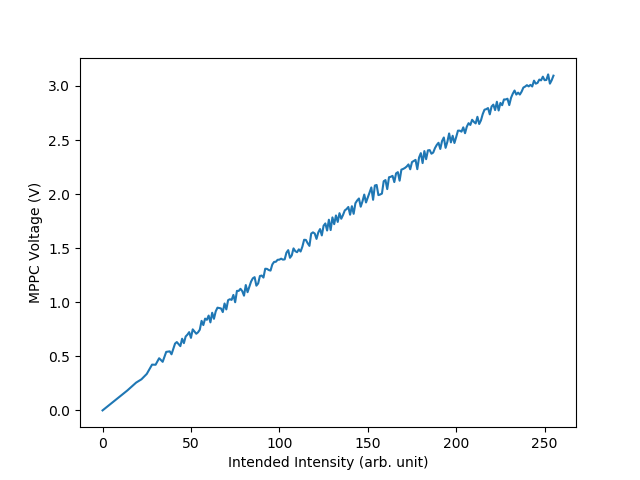

In [42]:
""" input output calibrtion for uncorrected phone pixel ramps """

plt.figure()
x = (lut_p[:-1] != lut_p[1:]).nonzero().flatten()
y = df_volTraces.loc[(slice(None),0.001,1),slice(None)].values
plt.plot(lut_p.unique(), np.nanmean(y, axis=1))
#plt.plot(lut_p.unique()[0:50:10], y)
plt.xlabel("Intended Intensity (arb. unit)")
plt.ylabel("MPPC Voltage (V)")
plt.show()

# Troubleshooting Blocks

In [24]:
# Debug alignment 
from PIL import Image
imToPhone_PIL = Image.open((phoneImagePath /  "RandBin_128x128_STL10_fixedrates_10x11_onsite_spar1"  / f"phone_random_binary_corr_0_r100.png").as_posix())
imToPhone_byte = PIL_to_bytestream(imToPhone_PIL)
aoab.write(imToPhone_byte)
imToSLM = Image.open((slmWeightPath /  "RandBin_128x128_STL10_fixedrates_10x11_onsite_spar1" / "slm_random_binary_0_r100.bmp").as_posix())
slm.updateArray(np.array(imToSLM))

In [25]:
# Debug alignment 
from PIL import Image
imToPhone_PIL = Image.open((phoneImagePath /  "RandBin_128x128_STL10_fixedrates_10x11_onsite_spar1"  / f"phone_random_binary_0_r100.png").as_posix())
imToPhone_byte = PIL_to_bytestream(imToPhone_PIL)
aoab.write(imToPhone_byte)
imToSLM = Image.open((slmWeightPath /  "RandBin_128x128_STL10_fixedrates_10x11_onsite_spar1" / "slm_random_binary_0_r100.bmp").as_posix())
slm.updateArray(np.array(imToSLM))

In [26]:
cam.roi = (1343,1843,1000,1500)
cam.exp_res = 0 # 1 for us, 0 for ms
cam.exp_time = 32 # 100 cam.exp_res units
greenBlock_PIL = Image.open((phoneLoadPath / f"phone_random_binary_corr_{unit_len}x_0_r100.png").as_posix())
# greenBlock_PIL = Image.open((resultPath / "phone_images" / "blocks_ramp" / "array_18x18_block_size_24x24_intensity_223.png").as_posix())
# greenBlock_PIL = Image.open((resultPath / "phone_images" / "green600x600_block.png").as_posix())
greenBlock_byte = PIL_to_bytestream(greenBlock_PIL)
aoab.write(greenBlock_byte)
slmPattern_PIL = Image.open((slmLoadPath / f"slm_random_binary_{unit_len}x_0_r100.bmp").as_posix())
slm.updateArray(np.array(slmPattern_PIL))
time.sleep(1)
imglist = cam.get_sequence(2)
fig, ax = plt.subplots()
ax.imshow(imglist[1,:,:])

NameError: name 'cam' is not defined

In [28]:
blackImage_PIL = Image.open((phoneImagePath / "black.png").as_posix())
blackImage_byte = PIL_to_bytestream(blackImage_PIL)
aoab.write(blackImage_byte) 

In [29]:
500E-12*0.1E-6*50/4E-19/128**2

0.3814697265625